In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
import numpy as np
import pandas as pd
import scipy.sparse as ssp
from functools import lru_cache
from tqdm import tqdm, trange
import xgboost as xgb 
from sklearn.model_selection import GroupKFold
import time
import matplotlib.pyplot as plt

In [2]:
merged_candidates_feature_test_path = '/root/autodl-tmp/xiaolong/WorkSpace/Amazon-KDDCUP-23/XGBoost/candidates_phase2/merged_candidates_150_test_feature.parquet'
merged_candidates_feature_path = '/root/autodl-tmp/xiaolong/WorkSpace/Amazon-KDDCUP-23/XGBoost/candidates_phase2/merged_candidates_150_feature.parquet'

In [3]:
@lru_cache(maxsize=1)
def read_merged_candidates_feature_test():
    return pd.read_parquet(merged_candidates_feature_test_path, engine='pyarrow')

@lru_cache(maxsize=1)
def read_merged_candidates_feature():
    return pd.read_parquet(merged_candidates_feature_path, engine='pyarrow')

In [4]:
candidates = read_merged_candidates_feature()

In [5]:
test_candidates = read_merged_candidates_feature_test()

In [6]:
len(test_candidates)

96556035

In [7]:
(test_candidates['product_freq'] <= 1.0).sum()

1772181

In [8]:
test_candidates.query('sess_id==50505').sort_values(by=['sasrec_scores_3'], ascending=False)[:25]

,sess_id,sess_locale,product,sasrec_scores_2,normalized_sasrec_scores_2,sasrec_scores_3,normalized_sasrec_scores_3,sess_avg_price,product_price,seqmlp_scores,...,gru4rec_feat_scores_2,normalized_gru4rec_feat_scores_2,sasrec_duorec_score,normalized_sasrec_duorec_score,w2v_l1_score,w2v_l2_score,w2v_l3_score,normalized_w2v_l1_score,normalized_w2v_l2_score,normalized_w2v_l3_score
15164006,50505,DE,B08X4LQ154,18.314672,0.352785,17.348755,0.278302,19.99,13.990000,18.214016,...,17.551813,0.154086,19.128878,0.232843,33.762428,42.610977,42.286411,0.022604,9.966255e-01,9.930473e-01
15164007,50505,DE,B08X4MBB7V,17.557625,0.165473,16.810863,0.162522,19.99,18.990000,17.176191,...,17.608105,0.163009,18.693102,0.150594,30.628727,32.594196,32.721939,0.000985,4.449378e-05,6.969032e-05
15163994,50505,DE,B08VZCB5R2,16.608877,0.064076,15.693432,0.053164,19.99,18.900000,17.157967,...,16.221859,0.040754,17.454603,0.043645,33.789444,33.295971,34.326099,0.023223,8.975862e-05,3.466174e-04
15164063,50505,DE,B09N7JX75C,15.248867,0.016446,15.150209,0.030882,19.99,27.900000,15.513212,...,15.774124,0.026045,16.882620,0.024634,31.441126,27.697006,27.988735,0.002218,3.322590e-07,6.131520e-07
15164008,50505,DE,B08X4N9FZ6,15.803396,0.028634,15.125531,0.030129,19.99,24.990000,16.144485,...,16.303230,0.044209,17.328751,0.038484,30.053822,30.876825,30.693130,0.000554,7.988304e-06,9.163726e-06
15164094,50505,DE,B0B4DXCCH3,15.453727,0.020184,15.120103,0.029966,19.99,49.990002,14.984374,...,15.445450,0.018749,17.122953,0.031326,26.864525,27.126884,27.460217,0.000023,1.878780e-07,3.614393e-07
15163990,50505,DE,B08T97QH84,15.124459,0.014522,14.975269,0.025925,19.99,29.900000,15.065176,...,13.690086,0.003241,16.680397,0.020123,32.951035,29.753531,30.178320,0.010041,2.597849e-06,5.476369e-06
15164107,50505,DE,B0BHS7BT4X,15.885178,0.031074,14.808543,0.021944,19.99,15.990000,16.390392,...,16.507029,0.054202,16.807665,0.022855,32.987556,31.681553,31.740723,0.010415,1.786255e-05,2.612375e-05
15164084,50505,DE,B0B15MX2HM,15.456314,0.020237,14.740116,0.020493,19.99,36.761604,15.940210,...,16.377371,0.047611,16.640657,0.019339,34.820351,32.167332,32.576344,0.065107,2.903450e-05,6.024779e-05
15164093,50505,DE,B0B4DWJMX3,14.962668,0.012352,14.723795,0.020161,19.99,39.990002,14.313828,...,15.926631,0.030336,16.767075,0.021946,27.871643,28.321423,28.607668,0.000062,6.203793e-07,1.138590e-06


In [9]:
test_candidates['sess_locale'] = test_candidates['sess_locale'].astype('category')

In [10]:
FEATURES = ['product_freq', 'product_price',
             'sasrec_scores_2', 'normalized_sasrec_scores_2', 
             'sasrec_scores_3', 'normalized_sasrec_scores_3', 
             'gru4rec_scores_2', 'normalized_gru4rec_scores_2',
             'seqmlp_scores', 'normalized_seqmlp_scores',
             'narm_scores', 'normalized_narm_scores',
             'sasrec_feat_scores_3', 'normalized_sasrec_feat_scores_3',
             'sasrec_cat_scores_3', 'normalized_sasrec_cat_scores_3',
             'gru4rec_feat_scores_2', 'normalized_gru4rec_feat_scores_2',
             'narm_feat_scores', 'normalized_narm_feat_scores',
             'all_items_co_graph_count_0', 'normalized_all_items_co_graph_count_0',
             'all_items_co_graph_count_1', 'normalized_all_items_co_graph_count_1',
             'all_items_co_graph_count_2', 'normalized_all_items_co_graph_count_2',
             'co_graph_counts_0', 'normalized_co_graph_counts_0',
             'co_graph_counts_1', 'normalized_co_graph_counts_1',
             'co_graph_counts_2', 'normalized_co_graph_counts_2',
             'desc_BM25_scores', 'title_BM25_scores',
             'roberta_scores', 'normalized_roberta_scores',
             'text_bert_scores', 'normalized_text_bert_scores',
             'sess_avg_price', 'sess_locale']
FEATURES.sort()
FOLDS = 5
TOPK = 100
ckpt_list = []
for i in range(FOLDS):
    ckpt_list.append(f'./ckpt/XGB_2023_06_04_02_21_05_fold{i}.json')

In [11]:
# FEATURES = ['product_freq', 'product_price',
#              'sasrec_scores_2', 'normalized_sasrec_scores_2', 
#              'sasrec_scores_3', 'normalized_sasrec_scores_3', 
#              'gru4rec_scores_2', 'normalized_gru4rec_scores_2',
#              'seqmlp_scores', 'normalized_seqmlp_scores',
#              'sess_avg_price', 'sess_locale']
# FEATURES.sort()
# FOLDS = 5
# TOPK = 100
# ckpt_list = []
# for i in range(FOLDS):
#     ckpt_list.append(f'./ckpt/XGB_2023_06_02_20_52_28_fold{i}.json')

In [12]:
FEATURES

['all_items_co_graph_count_0',
 'all_items_co_graph_count_1',
 'all_items_co_graph_count_2',
 'co_graph_counts_0',
 'co_graph_counts_1',
 'co_graph_counts_2',
 'desc_BM25_scores',
 'gru4rec_feat_scores_2',
 'gru4rec_scores_2',
 'narm_feat_scores',
 'narm_scores',
 'normalized_all_items_co_graph_count_0',
 'normalized_all_items_co_graph_count_1',
 'normalized_all_items_co_graph_count_2',
 'normalized_co_graph_counts_0',
 'normalized_co_graph_counts_1',
 'normalized_co_graph_counts_2',
 'normalized_gru4rec_feat_scores_2',
 'normalized_gru4rec_scores_2',
 'normalized_narm_feat_scores',
 'normalized_narm_scores',
 'normalized_roberta_scores',
 'normalized_sasrec_cat_scores_3',
 'normalized_sasrec_feat_scores_3',
 'normalized_sasrec_scores_2',
 'normalized_sasrec_scores_3',
 'normalized_seqmlp_scores',
 'normalized_text_bert_scores',
 'product_freq',
 'product_price',
 'roberta_scores',
 'sasrec_cat_scores_3',
 'sasrec_feat_scores_3',
 'sasrec_scores_2',
 'sasrec_scores_3',
 'seqmlp_scores'

In [13]:
len(FEATURES)

40

In [14]:
test_candidates_1 = test_candidates.query('sess_id<=180000')

In [15]:
test_candidates_2 = test_candidates.query('sess_id>180000')

In [16]:
test_candidates_1

,sess_id,sess_locale,product,sasrec_scores_2,normalized_sasrec_scores_2,sasrec_scores_3,normalized_sasrec_scores_3,sess_avg_price,product_price,seqmlp_scores,...,gru4rec_feat_scores_2,normalized_gru4rec_feat_scores_2,sasrec_duorec_score,normalized_sasrec_duorec_score,w2v_l1_score,w2v_l2_score,w2v_l3_score,normalized_w2v_l1_score,normalized_w2v_l2_score,normalized_w2v_l3_score
0,0,DE,B000Q87D0Q,0.000000,3.282997e-10,0.000000,6.689660e-10,67.527199,36.761604,0.000000,...,0.000000,4.436458e-10,0.000000,4.888735e-09,0.000000,0.000000,0.000000,6.725470e-18,1.902335e-18,3.300965e-19
1,0,DE,B000QB30DW,0.501346,5.420036e-10,-0.588501,3.713825e-10,67.527199,9.990000,7.260942,...,5.122046,7.438971e-08,5.116123,8.148930e-07,31.385134,31.193865,23.269724,2.871528e-04,6.708266e-05,4.212632e-09
2,0,DE,B004BIG55Q,6.917523,3.315223e-07,5.737720,2.076175e-07,67.527199,8.990000,2.454817,...,8.643940,2.517977e-06,6.817140,4.465219e-06,12.718339,14.284587,15.588253,2.245055e-12,3.040915e-12,1.943270e-12
3,0,DE,B0053FTNQY,-0.100895,2.967921e-10,1.507319,3.020121e-09,67.527199,36.761604,3.837643,...,-2.595809,3.308954e-11,2.309990,4.925070e-08,27.256227,27.248238,30.282482,4.623298e-06,1.297317e-06,4.679029e-06
4,0,DE,B007QWII1S,3.768980,1.422714e-08,4.594047,6.615662e-08,67.527199,54.950001,4.923371,...,7.384109,7.143555e-07,7.491323,8.762675e-06,23.500416,25.993063,20.459011,1.080995e-07,3.697691e-07,2.534407e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54650939,180000,JP,B0BKPS29N4,7.977071,1.346597e-04,8.527641,4.271428e-04,3547.333252,5780.000000,9.196325,...,10.546945,1.524732e-04,7.737038,2.590784e-04,25.110577,20.867350,21.567198,5.556912e-09,4.261493e-06,2.407388e-06
54650940,180000,JP,B0BKPYVKN8,2.081243,3.704349e-07,1.794754,5.087651e-07,3547.333252,9500.000000,0.717160,...,2.285335,3.937514e-08,5.471904,2.689650e-05,17.750113,19.759943,21.277363,3.533659e-12,1.408060e-06,1.801658e-06
54650941,180000,JP,B0BKPZFWKZ,5.002909,6.879794e-06,4.566021,8.129489e-06,3547.333252,9500.000000,6.327416,...,7.022513,4.493167e-06,6.050485,4.797006e-05,20.169027,22.424852,24.441807,3.969593e-11,2.022910e-05,4.265529e-05
54650942,180000,JP,B0BKZRS7QG,6.943507,4.790341e-05,8.247812,3.228828e-04,3547.333252,3980.000000,7.539568,...,10.030631,9.098325e-05,8.424062,5.149934e-04,23.578487,22.837029,23.366693,1.200758e-09,3.054798e-05,1.455651e-05


In [17]:
test_candidates_2

,sess_id,sess_locale,product,sasrec_scores_2,normalized_sasrec_scores_2,sasrec_scores_3,normalized_sasrec_scores_3,sess_avg_price,product_price,seqmlp_scores,...,gru4rec_feat_scores_2,normalized_gru4rec_feat_scores_2,sasrec_duorec_score,normalized_sasrec_duorec_score,w2v_l1_score,w2v_l2_score,w2v_l3_score,normalized_w2v_l1_score,normalized_w2v_l2_score,normalized_w2v_l3_score
54650944,180001,JP,B0000TCI7Y,8.798677,7.794003e-05,9.978222,1.272955e-04,295.000000,1417.000000,5.803704,...,7.465251,2.616142e-05,9.717299,3.878308e-04,28.145010,28.145010,0.000000,3.724032e-10,3.724032e-10,3.174603e-03
54650945,180001,JP,B000CEIZPQ,0.412768,1.777487e-08,0.906124,1.461675e-08,295.000000,766.000000,-2.088184,...,4.490109,1.335283e-06,3.207862,5.776034e-07,19.913532,19.913532,0.000000,9.911243e-14,9.911243e-14,3.174603e-03
54650946,180001,JP,B000CQ739I,-1.664021,2.227760e-09,-2.254187,6.199337e-10,295.000000,1380.000000,-3.617690,...,-1.012667,5.441871e-09,0.456228,3.686469e-08,29.394764,29.394764,0.000000,1.299496e-09,1.299496e-09,3.174603e-03
54650947,180001,JP,B000FP3EJY,4.255932,8.296047e-07,2.987470,1.171569e-07,295.000000,160.000000,4.768157,...,9.168712,1.437026e-04,8.596125,1.263929e-04,20.545803,20.545803,0.000000,1.865176e-13,1.865176e-13,3.174603e-03
54650948,180001,JP,B000FQNCEA,12.303469,2.593415e-03,12.451832,1.510386e-03,295.000000,495.000000,10.095582,...,12.663805,4.735484e-03,12.658804,7.347200e-03,32.393398,32.393398,0.000000,2.606544e-08,2.606544e-08,3.174603e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96556030,316971,UK,B0B82N3CQQ,-1.076433,6.007382e-08,-0.457645,1.105378e-07,19.459999,13.990000,6.433315,...,4.623051,4.508018e-07,3.866317,1.910537e-06,14.294576,13.684182,18.628992,7.488371e-10,8.704190e-10,1.966086e-12
96556031,316971,UK,B0BB9NW3F3,0.000000,1.762683e-07,0.000000,1.746882e-07,19.459999,22.097065,0.000000,...,0.000000,4.428127e-09,0.000000,3.999773e-08,0.000000,0.000000,0.000000,4.638013e-16,9.925754e-16,1.596372e-20
96556032,316971,UK,B0BDMVKTQ3,-1.079334,5.989980e-08,-1.901198,2.609658e-08,19.459999,41.990002,-1.094359,...,1.618663,2.234583e-08,1.900935,2.676707e-07,22.474419,23.814653,33.746994,2.672071e-06,2.184420e-05,7.232148e-06
96556033,316971,UK,B0BHW1D5VP,6.722834,1.465088e-04,6.111193,7.876277e-05,19.459999,26.990000,8.700006,...,11.669815,5.180317e-04,9.440860,5.036731e-04,21.862946,22.688568,29.340395,1.449735e-06,7.084080e-06,8.820754e-08


In [18]:
preds_1 = np.zeros(len(test_candidates_1))

for fold in range(FOLDS):
    model = xgb.Booster()
    model.load_model(ckpt_list[fold])
    model.set_param({'predictor': 'gpu_predictor'})
    dtest = xgb.DMatrix(data=test_candidates_1[FEATURES], enable_categorical=True)
    # dtest = xgb.DMatrix(data=test_candidates[FEATURES])
    preds_1 += model.predict(dtest) / FOLDS

In [19]:
preds_2 = np.zeros(len(test_candidates_2))

for fold in range(FOLDS):
    model = xgb.Booster()
    model.load_model(ckpt_list[fold])
    model.set_param({'predictor': 'gpu_predictor'})
    dtest = xgb.DMatrix(data=test_candidates_2[FEATURES], enable_categorical=True)
    # dtest = xgb.DMatrix(data=test_candidates[FEATURES])
    preds_2 += model.predict(dtest) / FOLDS

In [20]:
preds = np.concatenate([preds_1, preds_2], axis=0)

In [21]:
preds

array([-12.13703871,  -6.16957879,  -5.56747711, ...,  -9.0108124 ,
        -2.61868322,  -3.01037467])

In [ ]:
predictions = test_candidates[['sess_id','sess_locale', 'product']].copy()
predictions = predictions[test_candidates['product_freq'] > 1]
preds = preds[test_candidates['product_freq'] > 1]
predictions['pred'] = preds
predictions = predictions.sort_values(['sess_id','pred'], ascending=[True, False]).reset_index(drop=True)
predictions['n'] = predictions.groupby('sess_id')['product'].cumcount().astype('int32')
predictions = predictions.loc[predictions['n'] < TOPK]

In [25]:
sub = pd.DataFrame({})
sub['next_item_prediction'] = predictions.groupby('sess_id')['product'].apply(list)
sub['locale'] = predictions.groupby('sess_id')['sess_locale'].apply(lambda x : x.iloc[0])
sub.reset_index(drop=True, inplace=True)

In [26]:
sub['next_item_prediction'].apply(len).describe()

count    316972.0
mean        100.0
std           0.0
min         100.0
25%         100.0
50%         100.0
75%         100.0
max         100.0
Name: next_item_prediction, dtype: float64

In [27]:
sub.to_parquet('../predictions/XGBoost/xgboost_06_04_16_25_freq_filter.parquet', engine='pyarrow')

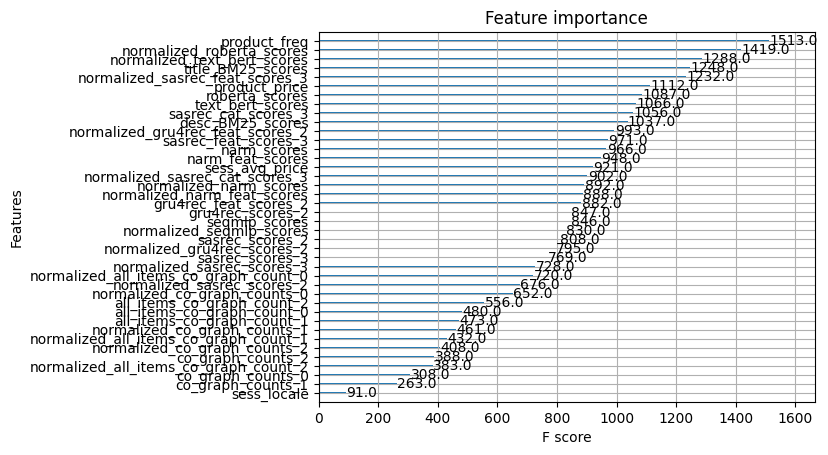

In [28]:
xgb.plot_importance(model)
plt.show()

In [57]:
# verify gru4rec scores
candidates[candidates['sess_id'] == 250052].sort_values(by=['all_items_co_graph_count_2'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'normalized_all_items_co_graph_count_2', 'all_items_co_graph_count_2']].iloc[:50]

,sess_locale,product,normalized_sasrec_scores_2,sasrec_scores_2,normalized_all_items_co_graph_count_2,all_items_co_graph_count_2
75310714,UK,B086RKQX31,2.624353e-05,10.640163,0.142857,5
75310808,UK,B09JFK6TSG,3.837457e-06,8.717554,0.057143,2
75310639,UK,B0736W5XNB,9.567715e-01,21.144064,0.057143,2
75310666,UK,B07J4RPWCM,2.894120e-07,6.132840,0.028571,1
75310811,UK,B09KHGHZGB,1.496599e-04,12.381109,0.028571,1
75310713,UK,B086RK2D9D,3.524666e-07,6.329945,0.028571,1
75310645,UK,B075VXSWJG,2.157713e-08,3.536623,0.028571,1
75310716,UK,B088FBT2KV,2.140622e-04,12.739011,0.028571,1
75310856,UK,B09YJ8M8DN,8.450939e-09,2.599266,0.028571,1
75310603,UK,B00R3Z49G6,6.657788e-07,6.965946,0.028571,1


In [60]:
# verify gru4rec scores
test_candidates[test_candidates['sess_id'] == 250052].sort_values(by=['all_items_co_graph_count_2'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'normalized_all_items_co_graph_count_2', 'all_items_co_graph_count_2']].iloc[:50]

,sess_locale,product,normalized_sasrec_scores_2,sasrec_scores_2,normalized_all_items_co_graph_count_2,all_items_co_graph_count_2
76112112,UK,B09R19452X,7.045467e-01,18.747795,0.092308,6
76112095,UK,B09NLSGKQY,2.322294e-01,17.637966,0.092308,6
76111921,UK,B079VZSC8R,9.280825e-03,14.418191,0.076923,5
76112152,UK,B0B9GC1QLH,5.079791e-09,0.000000,0.061538,4
76112163,UK,B0BFPD3HFQ,3.041778e-03,13.302683,0.046154,3
76111937,UK,B07JLZ38TK,1.436854e-03,12.552696,0.046154,3
76111885,UK,B00DB1HXNW,1.421892e-03,12.542229,0.030769,2
76111973,UK,B084BNW2PW,3.244701e-03,13.367264,0.030769,2
76112081,UK,B09GW4MZHZ,7.113118e-04,11.849596,0.030769,2
76112141,UK,B0B1BSDW8W,3.211836e-03,13.357083,0.030769,2


In [39]:
# verify gru4rec scores
test_candidates[test_candidates['sess_id'] == 150032].sort_values(by=['sasrec_scores_2'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'normalized_gru4rec_scores_2', 'gru4rec_scores_2']].iloc[:15]

,sess_locale,product,normalized_sasrec_scores_2,sasrec_scores_2,normalized_gru4rec_scores_2,gru4rec_scores_2
45410538,JP,B00D4I3RQE,0.149126,17.879353,0.175603,16.938869
45410489,JP,B006CQUMI6,0.137605,17.798954,0.048113,15.644196
45410561,JP,B00LIS5OTU,0.100575,17.485470,0.061075,15.882751
45410517,JP,B0091GJZA0,0.099371,17.473425,0.146275,16.756132
45410563,JP,B00LIS5TZE,0.079887,17.255173,0.038087,15.410515
45410672,JP,B07T9ZPM7J,0.056772,16.913614,0.023711,14.936587
45410671,JP,B07T46Y55W,0.050035,16.787277,0.037382,15.391848
45410494,JP,B006CQVELU,0.045869,16.700344,0.071903,16.045969
45410490,JP,B006CQUMUO,0.043309,16.642916,0.021996,14.861488
45410516,JP,B008JGUVOC,0.042844,16.632122,0.086083,16.225962


In [25]:
# verify gru4rec scores
test_candidates[test_candidates['sess_id'] == 150002].sort_values(by=['narm_scores'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'normalized_narm_scores', 'narm_scores']].iloc[:15]

,sess_locale,product,normalized_sasrec_scores_2,sasrec_scores_2,normalized_narm_scores,narm_scores
45401586,JP,B09NBSBMMY,0.778949,19.885757,0.742870,21.292591
45401541,JP,B08Z15DWMQ,0.060368,17.328272,0.091634,19.199871
45401623,JP,B0B1HVVJKP,0.006695,15.129188,0.021880,17.767664
45401582,JP,B09NBQQ492,0.003185,14.386286,0.012551,17.211887
45401593,JP,B09PYGCTDZ,0.008169,15.328185,0.010580,17.041069
45401636,JP,B0B6F9WW4W,0.001504,13.635960,0.010183,17.002754
45401637,JP,B0B6H7YFZK,0.009707,15.500629,0.009705,16.954704
45401514,JP,B0855VJ4PG,0.002875,14.283862,0.009394,16.922176
45401622,JP,B0B1HVFTRG,0.007881,15.292270,0.007036,16.633097
45401566,JP,B09G9Y83T3,0.009559,15.485256,0.007030,16.632198


In [48]:
# verify gru4rec scores
test_candidates[test_candidates['sess_id'] == 50002].sort_values(by=['sasrec_scores_2'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'sess_avg_price', 'product_price']].iloc[:15]

,sess_locale,product,normalized_sasrec_scores_2,sasrec_scores_2,sess_avg_price,product_price
15012764,DE,B01MZIBJHT,0.964333,17.545765,8.445,36.240002
15012916,DE,B09297QJKV,0.012449,13.195959,8.445,8.890000
15012718,DE,B002Q1BH3K,0.009770,12.953611,8.445,7.480000
15012740,DE,B00QDCL4CW,0.008417,12.804597,8.445,230.240005
15012871,DE,B08HR4D3Q7,0.002450,11.570552,8.445,24.950001
15012928,DE,B097GHM25G,0.001071,10.743021,8.445,30.990000
15012964,DE,B09VHWWSD4,0.000295,9.452239,8.445,799.989990
15012943,DE,B09G64XKWT,0.000217,9.147932,8.445,8.000000
15012847,DE,B08CZXQH9B,0.000105,8.419291,8.445,329.000000
15012897,DE,B08T1TYDXL,0.000103,8.401633,8.445,189.990005


In [61]:
# verify gru4rec scores
test_candidates[test_candidates['sess_id'] == 150013].sort_values(by=['sasrec_scores_2'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'normalized_co_graph_counts_2', 'co_graph_counts_2']].iloc[:15]

,sess_locale,product,normalized_sasrec_scores_2,sasrec_scores_2,normalized_co_graph_counts_2,co_graph_counts_2
45405097,JP,B09Q8SFVPY,0.419675,15.116422,0.277311,33.0
45405016,JP,B07LF84D5H,0.316771,14.835120,0.344538,41.0
45404869,JP,B00F437FKQ,0.081453,13.476970,0.109244,13.0
45404870,JP,B00F437GKK,0.074688,13.390257,0.033613,4.0
45404964,JP,B01MR4F8K3,0.016849,11.901218,0.025210,3.0
45404945,JP,B018VO4BPG,0.009728,11.351994,0.033613,4.0
45405000,JP,B07D86YRM2,0.009138,11.289371,0.008403,1.0
45405029,JP,B083Q9N2TS,0.006362,10.927288,0.008403,1.0
45405053,JP,B08TNNPG1F,0.004854,10.656667,0.000000,0.0
45404831,JP,B005UJ1FFA,0.004057,10.477363,0.016807,2.0


In [ ]:
# verify gru4rec scores
test_candidates[test_candidates['sess_id'] == 250013].sort_values(by=['sasrec_scores_2'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'normalized_gru4rec_scores_2', 'gru4rec_scores_2']].iloc[:15]

In [ ]:
# verify gru4rec scores
test_candidates[test_candidates['sess_id'] == 150002].sort_values(by=['sasrec_scores_2'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'normalized_gru4rec_scores_2', 'gru4rec_scores_2']].iloc[:15]

In [70]:
# verify gru4rec scores
candidates[candidates['sess_id'] == 50021].sort_values(by=['sasrec_scores_2'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'normalized_roberta_scores', 'roberta_scores']].iloc[:15]

,sess_locale,product,normalized_sasrec_scores_2,sasrec_scores_2,normalized_roberta_scores,roberta_scores
14930402,DE,B0933HYY8N,0.548652,19.150976,0.008795,281.700409
14930477,DE,B09XY2YJKX,0.125988,17.679695,0.007486,281.539307
14930401,DE,B0933HVCK5,0.087602,17.316311,0.008795,281.700409
14930390,DE,B08MQQ1567,0.074737,17.157482,0.050220,283.442688
14930388,DE,B08MQLFJDW,0.059612,16.931368,0.014220,282.180939
14930389,DE,B08MQMTYHB,0.022340,15.949873,0.044135,283.313507
14930437,DE,B09JWM8FG8,0.017162,15.686186,0.095558,284.085999
14930478,DE,B09XY3LXCB,0.016911,15.671474,0.028888,282.889679
14930450,DE,B09RSYCPZB,0.016810,15.665488,0.047642,283.389984
14930479,DE,B09XY45GCG,0.010719,15.215500,0.007486,281.539307


In [82]:
# verify gru4rec scores
test_candidates[test_candidates['sess_id'] == 251036].sort_values(by=['sasrec_scores_2'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'normalized_text_bert_scores', 'text_bert_scores']].iloc[:50]

,sess_locale,product,normalized_sasrec_scores_2,sasrec_scores_2,normalized_text_bert_scores,text_bert_scores
76411461,UK,B099JXBWN5,9.994345e-01,17.675999,3.297880e-01,439.645660
76411300,UK,B008YETL18,1.795076e-04,9.051271,1.695834e-06,427.467621
76411399,UK,B08BCT42Q4,1.216746e-04,8.662404,1.226866e-06,427.143921
76411438,UK,B0922KKF6D,1.050585e-04,8.515572,3.137818e-03,434.990723
76411420,UK,B08QMM3WPL,3.575017e-05,7.437609,2.072464e-02,436.878540
76411436,UK,B0922HQGFL,3.334917e-05,7.368087,5.012355e-03,435.459106
76411494,UK,B09PRPL81D,1.349261e-05,6.463196,1.980957e-05,429.925598
76411367,UK,B07R8WVBRP,1.294363e-05,6.421658,1.718655e-05,429.783569
76411335,UK,B0792KWV77,1.000814e-05,6.164453,8.075192e-08,424.423065
76411305,UK,B00H7ZELTC,8.015149e-06,5.942387,1.452732e-05,429.615479


In [84]:
# verify gru4rec scores
test_candidates[test_candidates['sess_id'] == 251036].sort_values(by=['sasrec_scores_2'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'desc_BM25_scores']].iloc[50:100]

,sess_locale,product,normalized_sasrec_scores_2,sasrec_scores_2,desc_BM25_scores
76411521,UK,B0BHTFG9XK,1.222114e-07,1.759051,120.073265
76411478,UK,B09LGYGTKJ,1.155718e-07,1.703190,235.352234
76411444,UK,B093W1NVLD,1.127215e-07,1.678219,35.483791
76411363,UK,B07Q44Q1JK,1.070998e-07,1.627059,138.797897
76411421,UK,B08QSD6P35,1.032619e-07,1.590567,50.328285
76411472,UK,B09GVY8R81,1.024605e-07,1.582776,305.123688
76411466,UK,B09DBTHYY7,9.980176e-08,1.556484,165.198380
76411453,UK,B097379B41,9.713390e-08,1.529389,195.435883
76411358,UK,B07PWMDQ6D,8.998522e-08,1.452944,10.519250
76411313,UK,B01D2GBRAU,8.893896e-08,1.441249,138.432419


In [97]:
# verify gru4rec scores
test_candidates[test_candidates['sess_id'] == 251336].sort_values(by=['title_BM25_scores'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'title_BM25_scores']].iloc[:50]

,sess_locale,product,normalized_sasrec_scores_2,sasrec_scores_2,title_BM25_scores
76502779,UK,B085NV2LYH,6.081121e-01,18.363018,211.327744
76502678,UK,B071NDD1QY,1.739418e-01,17.111380,211.327744
76502682,UK,B072DTJK5G,8.945307e-02,16.446373,208.751419
76502690,UK,B075RZ1S2C,6.755940e-03,13.863081,173.744629
76502780,UK,B085NVT68T,2.929256e-04,10.724822,169.190704
76502858,UK,B08SMFL25S,2.506501e-05,8.266376,165.296234
76502692,UK,B075RZT9KQ,1.973408e-03,12.632421,157.068802
76502691,UK,B075RZP4YJ,5.263951e-08,2.100615,153.355408
76502670,UK,B06XDD6BWV,2.348959e-07,3.596291,152.730804
76502791,UK,B08638FSYK,1.401773e-05,7.685226,150.628693


In [92]:
# verify gru4rec scores
candidates[candidates['sess_id'] == 151036].sort_values(by=['title_BM25_scores'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'title_BM25_scores']].iloc[:50]

,sess_locale,product,normalized_sasrec_scores_2,sasrec_scores_2,title_BM25_scores
45459546,JP,B06Y2Y6QQ5,3.200835e-01,17.505028,508.299561
45459543,JP,B06Y2XD4SK,1.521926e-01,16.761593,493.770966
45459547,JP,B06Y2YFBLX,3.280408e-03,12.924414,459.151398
45459540,JP,B06Y2TT11W,3.752452e-04,10.756270,446.232513
45459709,JP,B09TR197XB,7.786500e-03,13.788837,445.201965
45459550,JP,B071S1R7RW,4.090213e-04,10.842458,432.100159
45459541,JP,B06Y2VXP17,1.367911e-02,14.352316,402.032501
45459542,JP,B06Y2WQMNG,1.151085e-02,14.179736,402.032501
45459544,JP,B06Y2XSS5J,1.143463e-01,16.475677,402.032501
45459548,JP,B06Y2YFWNP,1.199636e-03,11.918464,402.032501


In [26]:
old_prediction = pd.read_parquet('/root/autodl-tmp/xiaolong/WorkSpace/Amazon-KDDCUP-23/predictions/XGBoost/xgboost_05_28_00_47_with_sasrec_feat_sasrec_text.parquet', engine='pyarrow')

In [31]:
new_data_1 = pd.read_parquet('/root/autodl-tmp/xiaolong/WorkSpace/Amazon-KDDCUP-23/predictions/XGBoost/xgboost_06_02_15_40_new_data.parquet', engine='pyarrow')

In [106]:
old_prediction.iloc[150000]['next_item_prediction'][:10]

array(['B0B71WY8SX', 'B09NJJNB2Y', 'B07YY9G6GG', 'B0883LWRYP',
       'B07P5QVBKJ', 'B08VGGFCLG', 'B07K7JC1NK', 'B08RB6CDXG',
       'B09G2PG8CW', 'B08XVW3WQ7'], dtype=object)

In [33]:
new_data_1.iloc[150000]['next_item_prediction'][:10]

array(['B09Q6GY8Y6', 'B09G2PG8CW', 'B08VGKFDBT', 'B0B71WY8SX',
       'B08RB6CDXG', 'B08XWB7S44', 'B09Q6CH3K3', 'B09F6R7VH2',
       'B08VGGYJMM', 'B08XWBS3WM'], dtype=object)

In [28]:
sub.iloc[150000]['next_item_prediction'][:10]

['B0B71WY8SX',
 'B09G2PG8CW',
 'B09NJJNB2Y',
 'B0B71XNYQK',
 'B08VGKFDBT',
 'B08XWB7S44',
 'B08RB6CDXG',
 'B09Q6GY8Y6',
 'B0883LWRYP',
 'B09F6R7VH2']

In [108]:
old_prediction.iloc[150001]['next_item_prediction'][:10]


array(['B09YR7NZRY', 'B013UIBM0K', 'B07XM4W3VB', 'B07XVJ7HV1',
       'B011QXFH3O', 'B011QXEVWM', 'B07XVK5ST6', 'B08HG9MQWS',
       'B08HGL5LPK', 'B0B369ZLCV'], dtype=object)

In [35]:
sub.iloc[150001]['next_item_prediction'][:10]

['B09YR7NZRY',
 'B013UIBM0K',
 'B011QXFH3O',
 'B07XM4W3VB',
 'B07XVJ7HV1',
 'B011QXEVWM',
 'B07XVK5ST6',
 'B08GKFJYL5',
 'B08HG9MQWS',
 'B09DYJTG6Y']

In [34]:
new_data_1.iloc[150001]['next_item_prediction'][:10]

array(['B013UIBM0K', 'B07XM4W3VB', 'B011QXEVWM', 'B011QXFH3O',
       'B08GKFJYL5', 'B09YR7NZRY', 'B07XVJ7HV1', 'B07XVK5ST6',
       'B09DYJTG6Y', 'B09DYJJSF6'], dtype=object)

In [111]:
old_prediction.iloc[150111]['next_item_prediction'][:10]

(array(['B07S8VWT59', 'B09DGTRV9Z', 'B07SC279N8', 'B06W9DXWY8',
        'B06WRN4VGJ', 'B0956X785M', 'B06X6BJ13P', 'B06VSKB9DB',
        'B08THKDN8R', 'B06WV7B1DR'], dtype=object),
 ['B0012GC9PA',
  'B005JUX9E0',
  'B00JUK55Y2',
  'B088R6Q51L',
  'B013HD5P9C',
  'B00828I77K',
  'B076Q5WCPP',
  'B07JWH5XBY',
  'B01N6X3UZB',
  'B077T73WWS'])

In [36]:
new_data_1.iloc[150111]['next_item_prediction'][:10]

array(['B07SC279N8', 'B09DGTRV9Z', 'B07S8VWT59', 'B06W9DXWY8',
       'B06WRN4VGJ', 'B0956PNZQ3', 'B08TGXFF8J', 'B01HO0WDS0',
       'B0956X785M', 'B08TGSMDL9'], dtype=object)

In [30]:
sub.iloc[150111]['next_item_prediction'][:10]

['B07S8VWT59',
 'B07SC279N8',
 'B09DGTRV9Z',
 'B06W9DXWY8',
 'B06WRN4VGJ',
 'B06X6BJ13P',
 'B01HLPWZPO',
 'B08THKDN8R',
 'B08TGWDKV4',
 'B00OPOCCNA']